## 1 - Download image chips from Google Earth Engine

This notebook represents the initial step in the application of a methodology for identifying reforestation projects in the Brazilian Atlantic Rainforest. Developed by Felipe Begliomini as part of his MRes dissertation for the AI4ER program at the University of Cambridge, this notebook serves as the foundation for the project.

The primary objective of this notebook is to provide the necessary steps for downloading image chips from Google Earth Engine. The data will be used to train a U-Net model, enabling the identification of reforestation projects within the Brazilian Atlantic Rainforest. Inspiration for this notebook was drawn from two key sources: [Fast(er) Downloads](https://gorelick.medium.com/fast-er-downloads-a2abd512aa26) and the [geemap notebook](https://geemap.org/notebooks/96_image_chips/).

#### Import files

In [1]:
import ee
from src.data.tools.download_gee import GetImageChips
from src.data.tools import vis
import geemap

#### Authenticate and Initialize GEE to use the high-volume endpoint

- [high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume)

In [2]:
# Uncoment the next line if you need to authinticate this device
#ee.Authenticate()

ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

#### Import the field data

In [3]:
# Import the rasterized data in raster format (5m)
ref_raster = ee.Image('users/fnincao/MRes/sudeste_data')

# Importe the reference data in poly format
ref_vector = ee.FeatureCollection('users/fnincao/MRes/polygons')

# Define the region of Interest
region = ref_raster.geometry()

#### Generate the points that will be used to create the image chips

In [4]:
def extract_centroid(feature):
    centroid = feature.centroid()
    return ee.Feature(centroid)

# Extract the centroid values from all polygons
points = ref_vector.map(extract_centroid).limit(50)


#### Generates the images to extract the chips

##### Reference Image

In [5]:
# Convert the reference image to a binary mask
ref_image = ref_raster\
        .where(ref_raster.gt(0), 1)\
        .unmask(0)\
        .toInt()

##### Planet Image (NIR / RED / GREEN) (5m)

In [6]:
# Create a composite from Planet basemap from Jan-Apr 2023
planet_image =  ee.ImageCollection("projects/planet-nicfi/assets/basemaps/americas")\
            .filterDate('2023-01-01','2023-04-01')\
            .median()\
            .select('N','R','G')


#### Sentinel-1 Images (Band-C VV and VH) (10m)

In [7]:
s1_image = ee.ImageCollection('COPERNICUS/S1_GRD')\
            .filterDate('2020-06-01', '2020-10-01')\
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))\
            .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))\
            .filter(ee.Filter.eq('instrumentMode', 'IW'))\
            .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))\
            .select('VH').mean()


#### Sentinel-2 Images (Red-Edge) (20m)

In [8]:
sentinel_image_2022 = ee.ImageCollection

sentinel_image_2021 = ee.ImageCollection

sentinel_image_2020 = ee.ImageCollection

sentinel_image_2019 = ee.ImageCollection

sentinel_image_2018 = ee.ImageCollection

#### Download the Reference images

In [9]:
GetImageChips(download_image=ref_image,
              out_resolution=5,
              points=points,
              out_dir='/maps/fnb25/data/images/1_reference',
              sulfix='_ref')

#### Download Planet images

In [10]:
GetImageChips(download_image=planet_image,
              out_resolution=5,
              points=points,
              out_dir='/maps/fnb25/data/images/3_planet',
              sulfix='_planet')

#### Download Sentinel-1 images

In [11]:
GetImageChips(download_image=s1_image,
              out_resolution=10,
              points=points,
              out_dir='/maps/fnb25/data/images/5_sentinel1',
              sulfix='_s1')

#### Download Sentinel-2 images

In [12]:
# GetImageChips(download_image=s1_image,
#               out_resolution=10,
#               points=points,
#               out_dir='/maps/fnb25/s1',
#               sulfix='_s1')

#### Visualize Image chips 

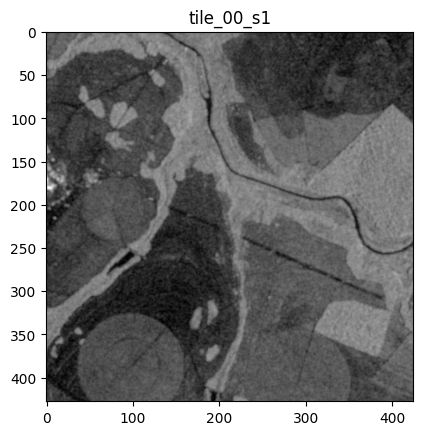

In [13]:
# Visualize planet chips
vis.viz_reference('/maps/fnb25/data/images/1_reference/tile_00_ref.tif')

# Visualize planet chips
vis.viz_planet('/maps/fnb25/data/images/3_planet/tile_00_planet.tif')

# Visualize s1 chips
vis.viz_s1('/maps/fnb25/data/images/5_sentinel1/tile_00_s1.tif')

# Visualize s2 chips
#vis.viz_s2('/maps/fnb25/s2/tile_00.tif')